# 📘 FrischMarkt Expiry Loss Analysis Notebook

* The Challenge:
FrischMarkt, a fresh food retailer, is currently experiencing significant financial strain due to alarmingly high levels of fresh food expiry and markdown losses. Our analysis of 2023 data reveals that these combined losses amounted to approximately 39.20% of total revenue, translating to nearly €5.8 million in avoidable losses. This substantial leakage directly impacts profitability and threatens the long-term sustainability of the business. The perishable nature of key product categories (e.g., Meat, Fresh Produce, Backwaren) coupled with operational inefficiencies and external variabilities, exacerbates this critical issue.

* Project Objective:
This project leveraged historical sales, inventory, product, store, and external factors data to pinpoint the primary drivers of these losses. The objective was to provide data-driven insights and actionable recommendations to help FrischMarkt optimize its fresh food inventory management, reduce waste, and improve its financial health.

## 📦 1. Imports & Configuration

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Directory containing generated CSV files
DATA_DIR = 'frischmarkt_data'


## 📊 2. Load Datasets

In [2]:
print("📊 Starting FrischMarkt Expiry Loss Analysis Project...")
print("-" * 50)
print("1. Loading Data...")

try:
    products_df = pd.read_csv(os.path.join(DATA_DIR, 'products_master.csv'))
    stores_df = pd.read_csv(os.path.join(DATA_DIR, 'stores_master.csv'))
    external_df = pd.read_csv(os.path.join(DATA_DIR, 'external_factors.csv'))
    inventory_df = pd.read_csv(os.path.join(DATA_DIR, 'inventory_daily.csv'))
    sales_df = pd.read_csv(os.path.join(DATA_DIR, 'sales_transactions.csv'))
    print("✅ All datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}")
    raise


📊 Starting FrischMarkt Expiry Loss Analysis Project...
--------------------------------------------------
1. Loading Data...
✅ All datasets loaded successfully.


## 🔍 3. Data Inspection & Preprocessing

In [3]:
# Convert 'date' columns
for df in [external_df, inventory_df, sales_df]:
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])

# Data types and structure checks
display(products_df.info(), stores_df.info(), external_df.info(), inventory_df.info(), sales_df.info())

# Convert relevant columns to numeric
for col in ['unit_cost', 'retail_price', 'shelf_life_days', 'base_expiry_rate', 'profit_margin']:
    if col in products_df.columns:
        products_df[col] = pd.to_numeric(products_df[col], errors='coerce').fillna(0)

for col in ['beginning_inventory', 'received_inventory', 'units_sold', 'units_expired', 'units_marked_down',
            'expiry_loss_eur', 'markdown_loss_eur', 'total_loss_eur', 'expiry_rate']:
    if col in inventory_df.columns:
        inventory_df[col] = pd.to_numeric(inventory_df[col], errors='coerce').fillna(0)

for col in ['quantity_sold', 'sale_price', 'discount_applied']:
    if col in sales_df.columns:
        sales_df[col] = pd.to_numeric(sales_df[col], errors='coerce').fillna(0)

print("✅ Data types converted and initial checks complete.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             45 non-null     object 
 1   product_name           45 non-null     object 
 2   category               45 non-null     object 
 3   subcategory            45 non-null     object 
 4   brand                  45 non-null     object 
 5   unit_cost              45 non-null     float64
 6   retail_price           45 non-null     float64
 7   shelf_life_days        45 non-null     int64  
 8   mhd_vs_verbrauch       45 non-null     object 
 9   seasonality_factor     45 non-null     float64
 10  temperature_sensitive  45 non-null     bool   
 11  supplier_id            45 non-null     object 
 12  expiry_risk_level      45 non-null     object 
 13  base_expiry_rate       45 non-null     float64
 14  profit_margin          45 non-null     float64
dtypes: bool(

None

None

None

None

None

✅ Data types converted and initial checks complete.


## 🔗 4. Merge DataFrames for Analysis



In [4]:
# Merge inventory with products and stores
analysis_df = inventory_df.merge(products_df, on='product_id', how='left')
analysis_df = analysis_df.merge(stores_df, on='store_id', how='left')
analysis_df = analysis_df.merge(external_df, on=['date', 'store_id'], how='left')

print("✅ All relevant datasets merged into 'analysis_df'")
print(f"Shape: {analysis_df.shape}")
display(analysis_df.head())


✅ All relevant datasets merged into 'analysis_df'
Shape: (67392, 55)


,date,store_id,product_id,beginning_inventory,received_inventory,units_sold,units_expired,units_marked_down,markdown_price,markdown_date,...,precipitation_mm,day_of_week,is_holiday,school_holidays,local_events,competitor_promotion,heat_wave,power_outage_risk,delivery_disruption,expiry_risk_multiplier
0,2023-01-02,S001,P040,0,69,61,0,0,NaN,NaN,...,6.5,Monday,False,False,False,False,False,False,False,1.0
1,2023-01-03,S001,P040,77,0,38,5,0,NaN,NaN,...,0.0,Tuesday,False,False,False,False,False,False,False,1.0
2,2023-01-04,S001,P040,34,56,62,1,0,NaN,NaN,...,0.0,Wednesday,False,False,False,False,False,False,False,1.0
3,2023-01-05,S001,P040,83,0,76,6,0,NaN,NaN,...,0.0,Thursday,False,False,False,False,False,False,False,1.0
4,2023-01-06,S001,P040,1,87,63,0,0,NaN,NaN,...,0.0,Friday,False,False,False,False,False,False,False,1.0


## 🧪 5. Feature Engineering



In [5]:
analysis_df['total_sales_value'] = analysis_df['units_sold'] * analysis_df['retail_price']
analysis_df['potential_revenue_if_no_loss'] = (analysis_df['units_sold'] + analysis_df['units_marked_down']) * analysis_df['retail_price']
analysis_df['net_profit_impact_of_loss'] = analysis_df['total_loss_eur']

display(analysis_df[['date', 'store_id', 'product_id', 'total_sales_value', 'total_loss_eur']].head())


,date,store_id,product_id,total_sales_value,total_loss_eur
0,2023-01-02,S001,P040,176.9,0.00
1,2023-01-03,S001,P040,110.2,11.10
2,2023-01-04,S001,P040,179.8,2.22
3,2023-01-05,S001,P040,220.4,13.32
4,2023-01-06,S001,P040,182.7,0.00


## 📈 6. Exploratory Data Analysis (EDA)

### 📅 6.1 Total Daily Loss Over Time

* Why It Matters:
Helps identify seasonal trends, operational failures, or unexpected spikes in loss, which can guide timely interventions.

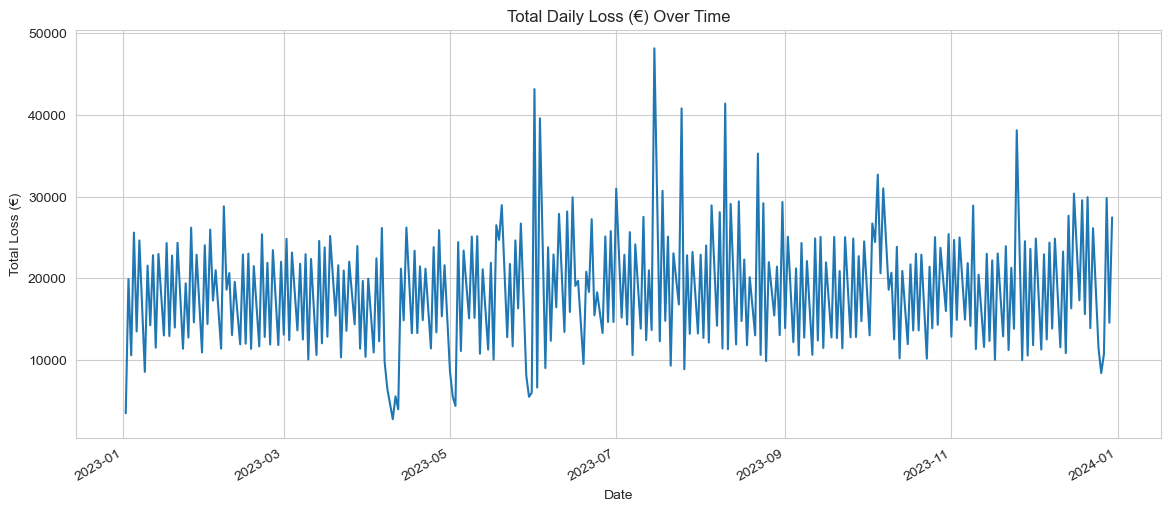

In [7]:
loss_trend = analysis_df.groupby('date')['total_loss_eur'].sum()
loss_trend.plot(figsize=(14,6), title="Total Daily Loss (€) Over Time")
plt.ylabel("Total Loss (€)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


### 💶 6.2 Total Daily Revenue Over Time

* Why It Matters:
Revenue trends help benchmark loss impact. For example, rising losses with flat or declining revenue signals efficiency issues.

 

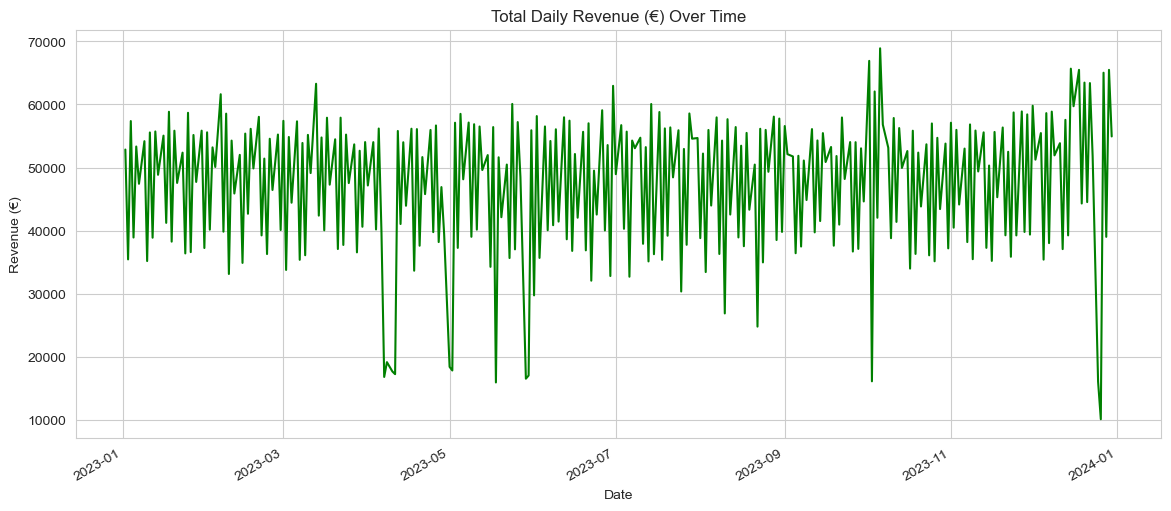

In [8]:
daily_revenue = sales_df.groupby('date').apply(lambda x: (x['quantity_sold'] * x['sale_price']).sum())
daily_revenue.plot(figsize=(14,6), title="Total Daily Revenue (€) Over Time", color='green')
plt.ylabel("Revenue (€)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


### 🧺 6.3 Total Loss by Product Category

* Why It Matters:
Pinpoints which categories contribute most to waste, helping to prioritize which product lines need better forecasting, markdowns, or supplier changes.

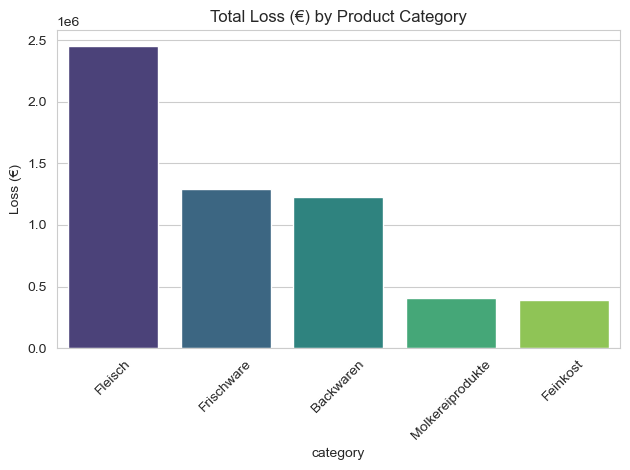

In [9]:
losses_by_category = analysis_df.groupby('category')['total_loss_eur'].sum().sort_values(ascending=False)
sns.barplot(x=losses_by_category.index, y=losses_by_category.values, palette='viridis')
plt.title("Total Loss (€) by Product Category")
plt.ylabel("Loss (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 🏬 6.4 Total Loss by Store 

* Why It Matters:
Reveals location-specific inefficiencies. This can help with store-level interventions, training, or layout optimization.

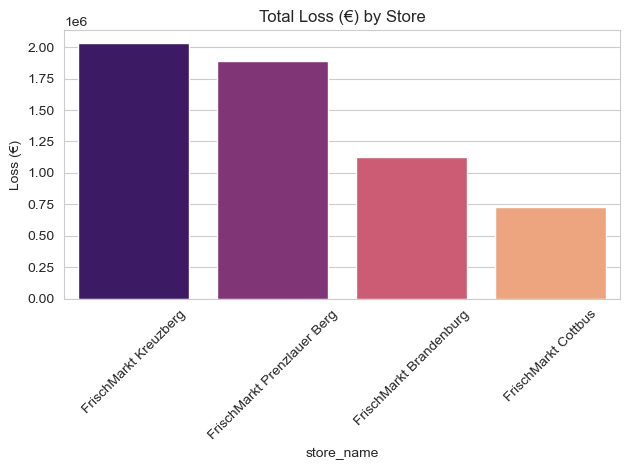

In [10]:
losses_by_store = analysis_df.groupby('store_name')['total_loss_eur'].sum().sort_values(ascending=False)
sns.barplot(x=losses_by_store.index, y=losses_by_store.values, palette='magma')
plt.title("Total Loss (€) by Store")
plt.ylabel("Loss (€)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 📉 6.5 Expiry Rate by Management Quality

* Why It Matters:
Links human operational performance to product expiry. Store teams with lower expiry rates under similar conditions might be models for others.

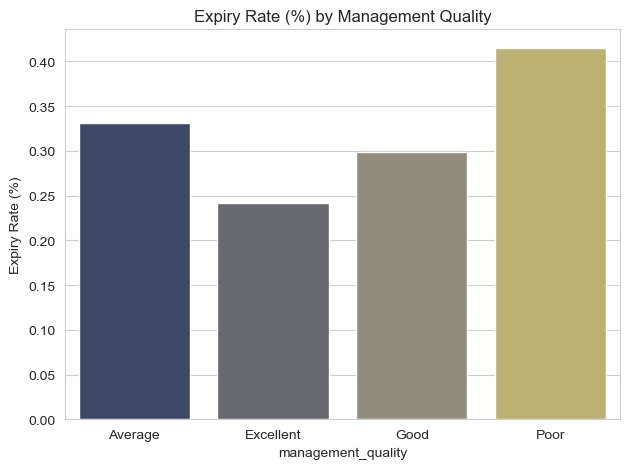

In [11]:
analysis_df['beginning_inventory_safe'] = analysis_df['beginning_inventory'].replace(0, np.nan)
expiry_rate_by_mgmt = analysis_df.groupby('management_quality').apply(
    lambda x: (x['units_expired'].sum() / x['beginning_inventory_safe'].sum())
).reset_index(name='expiry_rate')

sns.barplot(x='management_quality', y='expiry_rate', data=expiry_rate_by_mgmt, palette='cividis')
plt.title("Expiry Rate (%) by Management Quality")
plt.ylabel("Expiry Rate (%)")
plt.tight_layout()
plt.show()


### 🌡️ 6.6. Temperature vs Expiry Rate (Sensitive Products)

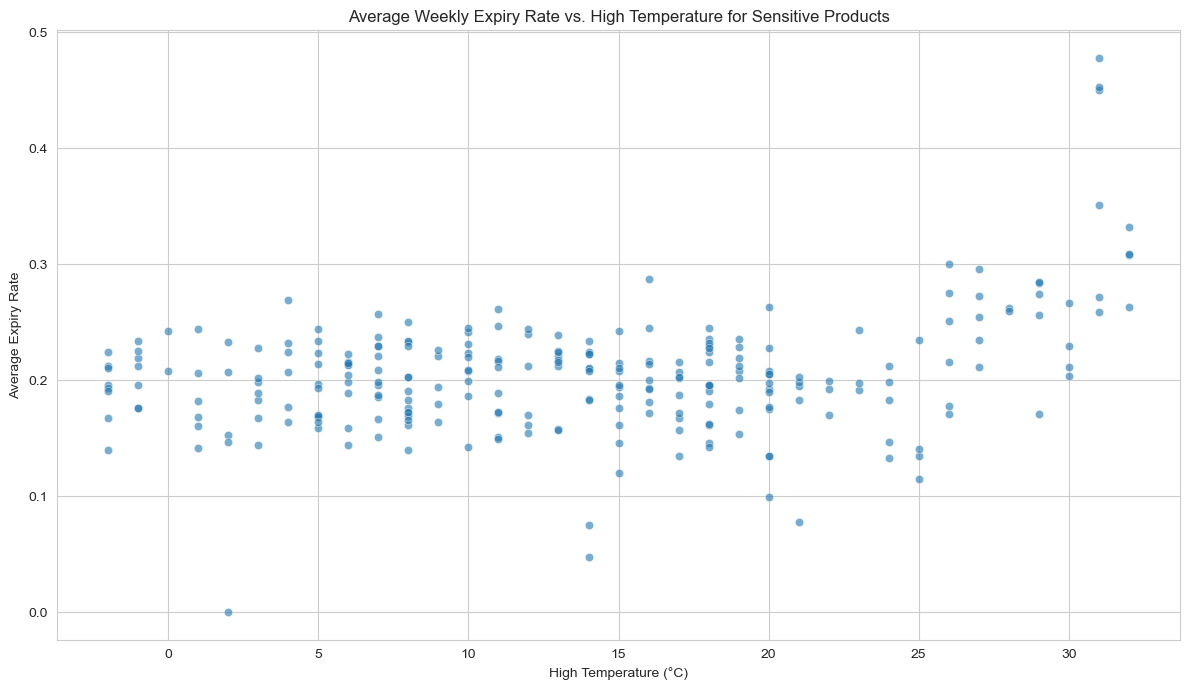

In [13]:
temp_sensitive_products = analysis_df[analysis_df['temperature_sensitive'] == True]

temp_sensitive_expiry = temp_sensitive_products.groupby(
    [pd.Grouper(key='date', freq='W'), 'temperature_high_c']
)['expiry_rate'].mean().reset_index()

plt.figure(figsize=(12, 7))
sns.scatterplot(x='temperature_high_c', y='expiry_rate', data=temp_sensitive_expiry, alpha=0.6)
plt.title('Average Weekly Expiry Rate vs. High Temperature for Sensitive Products')
plt.xlabel('High Temperature (°C)')
plt.ylabel('Average Expiry Rate')
plt.tight_layout()
plt.show()


## 🔍 7. Root Cause Analysis

### 🔺 7.1 Product Expiry Risk vs Actual Expiry Rate

* Why It Matters:
Validates whether products labeled as high-risk actually expire more — key for improving labeling, storage, and procurement strategies.

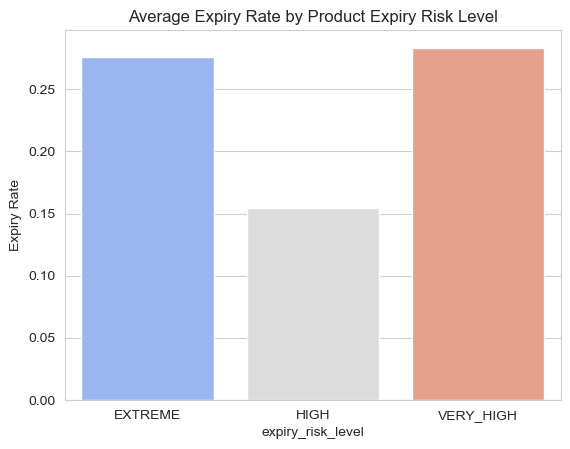

In [14]:
expiry_by_risk = analysis_df.groupby('expiry_risk_level')['expiry_rate'].mean().reset_index()
sns.barplot(x='expiry_risk_level', y='expiry_rate', data=expiry_by_risk, palette='coolwarm')
plt.title("Average Expiry Rate by Product Expiry Risk Level")
plt.ylabel("Expiry Rate")
plt.show()


### 🔻 7.2 Markdown Aggressiveness vs Markdown Outcomes

* Why It Matters:
Evaluates if more aggressive markdowns reduce waste or just shift loss from expiry to markdown, informing pricing tactics.


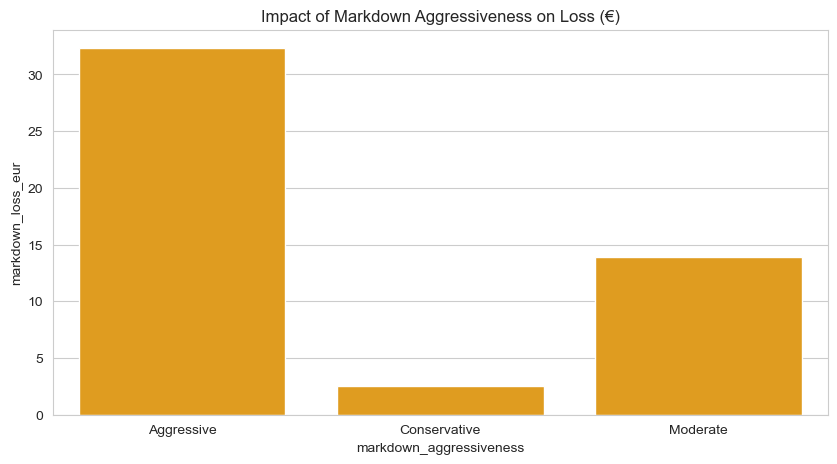

In [15]:
markdown_impact = analysis_df.groupby('markdown_aggressiveness')[['markdown_loss_eur', 'units_marked_down']].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))
sns.barplot(data=markdown_impact, x='markdown_aggressiveness', y='markdown_loss_eur', ax=ax1, color='orange')
plt.title("Impact of Markdown Aggressiveness on Loss (€)")
plt.show()


### 🚚 7.3 Supplier Shelf Life vs Expiry Loss

* Why It Matters:
Checks if shorter-than-promised shelf life leads to higher losses — crucial for supplier evaluation and contract enforcement.

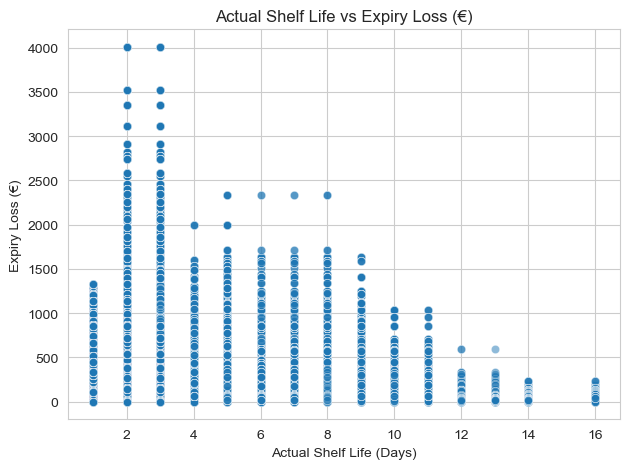

In [16]:
supplier_df = pd.read_csv(os.path.join(DATA_DIR, 'supplier_performance.csv'))
analysis_df = analysis_df.merge(supplier_df, on='product_id', how='left')

sns.scatterplot(data=analysis_df, x='actual_shelf_life_days', y='expiry_loss_eur', alpha=0.5)
plt.title("Actual Shelf Life vs Expiry Loss (€)")
plt.xlabel("Actual Shelf Life (Days)")
plt.ylabel("Expiry Loss (€)")
plt.tight_layout()
plt.show()


### 📦 7.4 Overstocking and Expiry

* Why It Matters:
High inventory leading to expiry or markdowns indicates inefficient ordering or forecasting, suggesting room for inventory optimization.

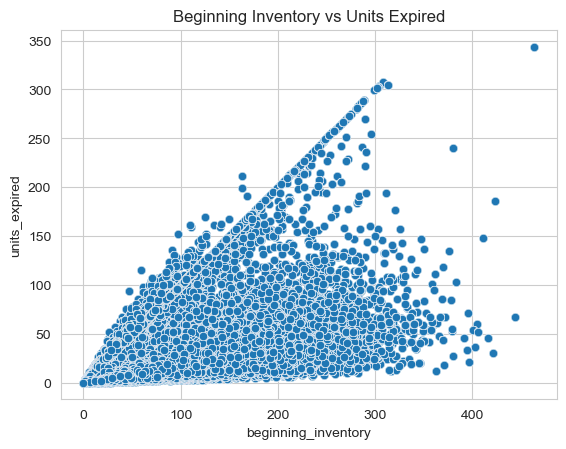

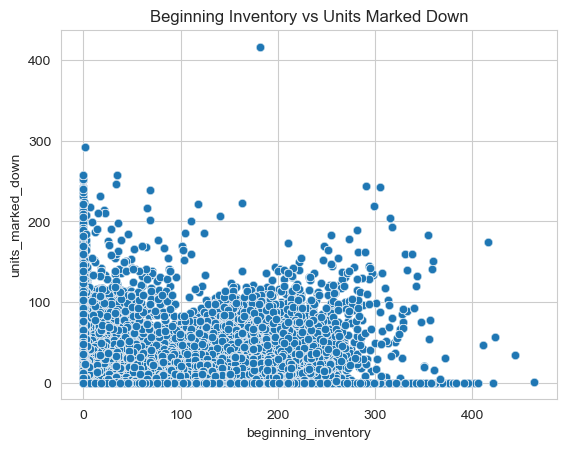

In [17]:
sns.scatterplot(data=analysis_df, x='beginning_inventory', y='units_expired', alpha=0.5)
plt.title("Beginning Inventory vs Units Expired")
plt.show()

sns.scatterplot(data=analysis_df, x='beginning_inventory', y='units_marked_down', alpha=0.5)
plt.title("Beginning Inventory vs Units Marked Down")
plt.show()
